# Project 4 - Vehicle Detection

In [1]:
# import libaries
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import numpy as np
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import glob
import time
import pickle
from skimage.feature import hog

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC, SVC
from sklearn.externals import joblib
from sklearn.model_selection import cross_val_score, cross_val_predict

%matplotlib inline

print('Libraries Imported!')

Libraries Imported!


## Load Images

In [2]:
cars = glob.glob('./images/vehicles/**/*.png', recursive=True)
notCars = glob.glob('./images/non-vehicles/**/*.png', recursive=True)

print('Number of Car Images: ', len(cars))
print('Number of Non Car Images: ',len(notCars))

Number of Car Images:  8792
Number of Non Car Images:  8968


In [3]:
# Show Random Examples
def plotExamples():
    plt.figure(figsize=(15,5))
    
    for i in range(5):
        carIdx = np.random.randint(0,len(cars))
        notCarIdx = np.random.randint(0,len(notCars))
        car = mpimg.imread(cars[carIdx])
        notCar = mpimg.imread(notCars[notCarIdx])
        
        plt.subplot(2,5,i+1)
        plt.imshow(car)
        plt.axis('off')
        plt.title(carIdx)
        plt.subplot(2,5,5+i+1)
        plt.imshow(notCar)
        plt.axis('off')
        plt.title(notCarIdx)
interact_manual(plotExamples)

<function __main__.plotExamples>

## Feature Extraction

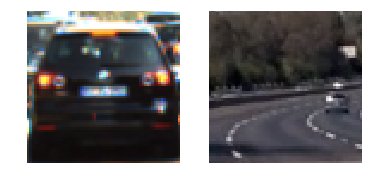

In [4]:
# Load Test Images
testImg_Car = cv2.imread(cars[8231])
testImg_NotCar = cv2.imread(notCars[4439])

# convert to RGB
testImg_Car = cv2.cvtColor(testImg_Car, cv2.COLOR_BGR2RGB)
testImg_NotCar = cv2.cvtColor(testImg_NotCar, cv2.COLOR_BGR2RGB)

plt.subplot(121)
plt.imshow(testImg_Car)
plt.axis('off')
plt.subplot(122)
plt.imshow(testImg_NotCar)
plt.axis('off')
plt.show()

### Functions

#### Color Spaces & Spatial Binning

In [5]:
def plot3d(pixels, colors_rgb, axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)]):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation

In [6]:
def convertCSpace(img, color_space='RGB'):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'BGR':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2RGB)
        elif color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        elif color_space == 'LAB':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    else: feature_image = np.copy(img)   
    return feature_image

In [7]:
# Function from course work
def bin_spatial(img, size=(32, 32), unravel=True):          
    # Use cv2.resize().ravel() to create the feature vector
    if unravel:
        features = cv2.resize(img, size).ravel()
    else:
        features = cv2.resize(img, size)
    return features

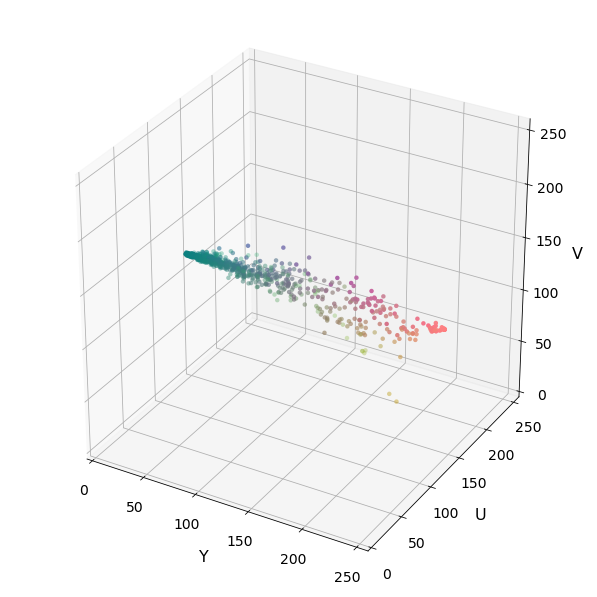

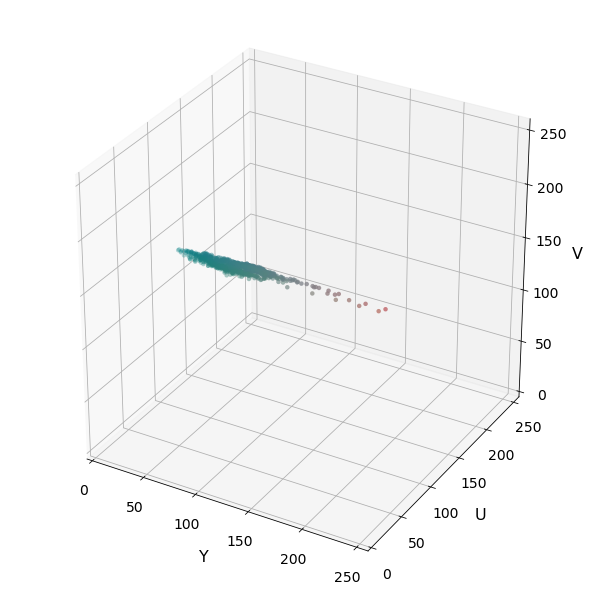

<function __main__.fSpatialColorSpace>

In [8]:
def fSpatialColorSpace(colorSpace):
    newImage = convertCSpace(testImg_Car, colorSpace)
    featureVec_Car = bin_spatial(newImage, unravel=False)
    
    newImage = convertCSpace(testImg_NotCar, colorSpace)
    featureVec_NotCar = bin_spatial(newImage, unravel=False)
    scaledFeatures_Car = featureVec_Car/255
    scaledFeatures_NotCar = featureVec_NotCar/255
    
    plot3d(featureVec_Car, scaledFeatures_Car, axis_labels=list(colorSpace))
    plt.show()
    plot3d(featureVec_NotCar, scaledFeatures_NotCar, axis_labels=list(colorSpace))
    plt.show()

interact(fSpatialColorSpace, colorSpace={'HSV':'HSV', 'LUV':'LUV','HLS':'HLS','YUV':'YUV','YCrCb':'YCrCb', 'RGB':'RGB'})

#### Histogram Extraction

In [9]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features

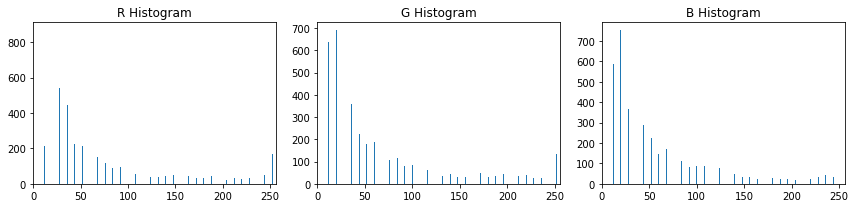

<function __main__.fColorHist>

In [10]:
# Interact with color hist
def fColorHist(nbins):
    rhist, ghist, bhist, bin_centers, hist_features = color_hist(testImg_Car, nbins)
    if rhist is not None:
        fig = plt.figure(figsize=(12,3))
        plt.subplot(131)
        plt.bar(bin_centers, rhist[0])
        plt.xlim(0, 256)
        plt.title('R Histogram')
        plt.subplot(132)
        plt.bar(bin_centers, ghist[0])
        plt.xlim(0, 256)
        plt.title('G Histogram')
        plt.subplot(133)
        plt.bar(bin_centers, bhist[0])
        plt.xlim(0, 256)
        plt.title('B Histogram')
        fig.tight_layout()
        plt.show()
interact(fColorHist, nbins=32)

#### Hog Transform

In [11]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

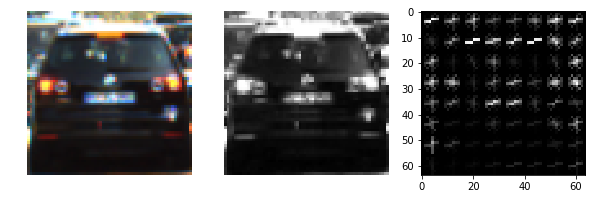

<function __main__.fHog>

In [12]:
def fHog(colorSpace='RGB', pixPerCell=8, cellPerBlock=2, orients=9, hogChannel=0):
    plt.figure(figsize=(10,5))
    plt.subplot(131)
    plt.imshow(testImg_Car)
    plt.axis('off')
    img = convertCSpace(testImg_Car, colorSpace)
    plt.subplot(132)
    plt.imshow(img[:,:,hogChannel], cmap='gray')
    plt.axis('off')
    _, hog_image = get_hog_features(img[:,:,hogChannel], orients, pixPerCell, cellPerBlock, True)
    plt.subplot(133)
    plt.imshow(hog_image, cmap='gray')
    plt.show()
interact(fHog, colorSpace={'HSV':'HSV', 'LUV':'LUV','HLS':'HLS','YUV':'YUV','YCrCb':'YCrCb', 'RGB':'RGB'}, 
             pixPerCell=(1,20), cellPerBlock=(0,9), orients=(0,20), hogChannel = (0,2))

## Build Classifier

In [32]:
# Function to get picture features
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256), 
                        orient=9, pixPerCell=8, cellPerBlock=2, hogChannel=0,
                        spatial_features=True, hist_features=True, hog_features=True):
    features=[]
    
    for img in imgs:
        image = cv2.imread(img)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Change color space
        image = convertCSpace(image, cspace)
        
        img_features = []
        # Get Spatial and histogram features
        if spatial_features:
            spatialFeatures = bin_spatial(image, spatial_size)
            img_features.append(spatialFeatures)
        if hist_features:
            _, _, _, _, histFeatures = color_hist(image, hist_bins, hist_range)
            img_features.append(histFeatures)
        # Get Hog Features
        if hog_features:
            if hogChannel == 'All':
                hogFeatures=[]
                for channel in range(image.shape[2]):
                    hogFeatures.append(get_hog_features(image[:,:,channel], 
                                        orient, pixPerCell, cellPerBlock, 
                                        vis=False, feature_vec=True))
                hogFeatures = np.ravel(hogFeatures)
            else:
                hogFeatures = get_hog_features(image[:,:,hogChannel], 
                                orient, pixPerCell, cellPerBlock, 
                                vis=False, feature_vec=True)
            img_features.append(hogFeatures)
        
        
        # Combine all features together
        features.append(np.concatenate(img_features))
    return features

In [33]:
# Get features from dataset
cspace = 'LAB' #'HSV','LUV',HLS','YUV','YCrCb', 'RGB'
spatial_size = (32,32)
hist_bins = 32
hist_range = (0,256)
orient = 12
pixPerCell = 8
cellPerBlock = 2
hogChannel = 'All'
spat_feat = True
hist_feat = True
hog_feat = True

t = time.time()
carFeatures = extract_features(cars, cspace, spatial_size, hist_bins, hist_range, 
                               orient, pixPerCell, cellPerBlock, hogChannel,
                                  spat_feat,hist_feat,hog_feat)
notCarFeatures = extract_features(notCars, cspace, spatial_size, hist_bins, hist_range, 
                               orient, pixPerCell, cellPerBlock, hogChannel,
                                  spat_feat,hist_feat,hog_feat)

print('Features Extracted!')

Features Extracted!


In [40]:
# Sort the Data
X = np.vstack((carFeatures, notCarFeatures)).astype(np.float64)

# Scale the data to make it even
scaler = StandardScaler().fit(X)
XScaled = scaler.transform(X)

# Create label vector
y = np.hstack((np.ones(len(carFeatures)), np.zeros(len(notCarFeatures))))

# Split data into training and testing sets
randState = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split( XScaled, y, 
                                        test_size=0.2, random_state=randState)
print('Data Sorted!')
t2 = time.time()
print('Time To Extract Features: ', round(t2-t,2), ' seconds')

Data Sorted!
Time To Extract Features:  31.15  seconds


In [44]:
# Fit the model
# parameters = {'C':[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0] , 'kernel':('linear', 'rbf')}
# svc = SVC()
# clf = GridSearchCV(svc, parameters)
clf = LinearSVC(C=0.001)
t = time.time()
clf.fit(X_train, y_train)
t2 = time.time()
print('Time To Fit the Model: ', round(t2-t,2), ' seconds')

acc = round(clf.score(X_test, y_test),4)
print('Model Accuracy: ', acc)

Time To Fit the Model:  6.62  seconds
Model Accuracy:  0.9932


In [ ]:
print(clf.best_params_)

In [38]:
scores = cross_val_score(svc, X_train, y_train, cv=5)
print("Accuracy: {:0.5} (+/- {:0.2})".format(scores.mean(), scores.std() * 2))

Accuracy: 0.93546 (+/- 0.007)


In [ ]:
pred = cross_val_predict(svc, X_test, y_test, cv=5) 

In [45]:
filename = './model/bestFit_{}.pkl'.format(acc)
joblib.dump(clf, filename)
filename = './model/scaler_{}.pkl'.format(acc)
joblib.dump(scaler, filename)

['./model/scaler_0.9932.pkl']

In [49]:
data = {'X_train':X_train, 'X_test':X_test, 'y_train':y_train, 'y_test':y_test}
pickle.dump(data, open('./model/dataset.pkl', 'wb'))

In [15]:
filename = './model/bestFit_0.9955.pkl'
svc = joblib.load(filename)

In [ ]:
acc = round(svc.score(X_test, y_test),4)
print('Model Accuracy: ', acc)

In [18]:
filename = './model/scaler.pkl'
joblib.dump(scaler, filename)

['./model/scaler.pkl']

In [51]:
filename = './model/bestFit_0.9918.pkl'
svc = joblib.load(filename)
filename = './model/scaler_0.9918.pkl'
scaler = joblib.load(filename)

In [54]:
problemImages = glob.glob('./problemImages/cars/*.png', recursive=True)
print(problemImages)

cspace = 'YCrCb' #'HSV','LUV',HLS','YUV','YCrCb', 'RGB'
spatial_size = (32,32)
hist_bins = 32
hist_range = (0,256)
orient = 8
pixPerCell = 8
cellPerBlock = 2
hogChannel = 'All'
carFeatures = extract_features(problemImages, cspace, spatial_size, hist_bins, hist_range, 
                               orient, pixPerCell, cellPerBlock, hogChannel, False)

['./problemImages/cars\\image_24.png', './problemImages/cars\\image_244.png', './problemImages/cars\\image_25.png', './problemImages/cars\\image_34.png', './problemImages/cars\\image_35.png', './problemImages/cars\\image_37.png', './problemImages/cars\\image_43.png', './problemImages/cars\\image_44.png', './problemImages/cars\\image_49.png']


In [55]:
featuresScaled = scaler.transform(carFeatures)
preds = svc.predict(featuresScaled)

In [56]:
print(preds)

[ 1.  0.  0.  1.  0.  0.  0.  0.  0.]
